In [18]:
# Imports...
import tqdm
import numpy as np

# Classical ML.
import torch
from torch.nn import Module
from torch.optim import Adam
from torch import manual_seed
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

# Quantum ML.
from qiskit_algorithms.utils import algorithm_globals
from qiskit.quantum_info.random import random_statevector
from qiskit_machine_learning.connectors import TorchConnector
from qiskit_machine_learning.neural_networks import SamplerQNN

# Version control.
from qiskit import __version__ as qiskit_version
from qiskit_machine_learning import __version__ as qml_version
from qiskit_algorithms import __version__ as alg_version
from torch import __version__ as torch_version

# Plotting.
from IPython.display import clear_output
import matplotlib.pyplot as plt
import seaborn as sns

# Scripts.
from scripts.utils import sample_n_states
from scripts.circuits import build_circuit
from scripts.learning import build_qnn_circuit, train_by_COBYLA, train_by_COBYLA_no_recylcing, train_by_torch

# Styling.
sns.set_context('paper')
sns.set_theme(style='darkgrid', palette='Dark2')

# Device management.
if torch.cuda.is_available(): device = torch.device('cuda')
else: device = torch.device('cpu')

# Random seed setting.
def set_seed(seed):
    algorithm_globals.random_seed = seed
    np.random.seed(seed)
    manual_seed(seed)
    
set_seed(42)

# Package versions (ignoring packages that obviously won't be a problem).
print('Important Package Versions...\n')
versions = [('qiskit', qiskit_version), ('qiskit_machine_learning', qml_version), ('qiskit_algorithms', alg_version), ('numpy', np.__version__), ('torch', torch_version)]

pad = max([len(x) for x, _ in versions])
for package, version in versions:
    print(f'{package:<{pad}} : {version}')

Important Package Versions...

qiskit                  : 1.1.1
qiskit_machine_learning : 0.7.2
qiskit_algorithms       : 0.3.0
numpy                   : 1.24.3
torch                   : 2.3.1


# Learning By Depth

We are now more confident that local inversion may be learnt by a variational/QNN approach. The next thing to think about is how well the learning generalises and scales in the complexity of the problem. To that end, we now explore:
- Is the performance of our method is a function of the unknown unitary's depth (i.e. if the loss cannot be brought to zero, then does it increase as a function of unitary depth)?
- What is the relationship between the depth of the ansatz required to reach a particular performance (e.g. loss no greater than 0.1) and the depth of the unknown unitary?
- How does the runtime scale in unitary depth (e.g. when the anstaz depth is kept fixed)?
- How many randomly distributed input samples are required to learn a unitary, and how does it depend on the depth of that unitary?

## Demonstrating the Learning Algorithm

### Preparing the model

In [44]:
# Sample a unitary to learn and choose the target qubits (to learn the local inversion for).
n, d = 4, 3
U = build_circuit(n=n, d=d)
target_qubits = [1, 2]

# Build a circuit for the QNN from U.
qnn_circuit, input_parameters, weight_parameters = build_qnn_circuit(U, ansatz_reps=5, target_qubits=target_qubits)

# Define a QNN object. 
qnn = SamplerQNN(
    circuit=qnn_circuit,
    input_params=input_parameters,
    weight_params=weight_parameters,
    interpret=lambda x: x, # I'm not actually sure you have to explicitly give an identity interpret.
    output_shape=2, # When specifying an interpret function, output shape cannot be implied, so we must state it.
    input_gradients=True # We must use input gradients to work correctly with PyTorch.
)

# Explicitly declare initial weights (else they will be uniformly randomly sampled from [-1, 1]).
initial_weights = .1 * (2 * algorithm_globals.random.random(qnn.num_weights) - 1)

# Define a PyTorch model from the QNN (and move it to device).
model = TorchConnector(qnn, initial_weights=initial_weights)
model = model.to(device)

### Building a dataset

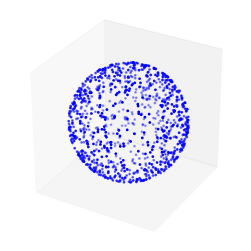

In [35]:
def sample_haar_random_state_angles(seed=None):
    # Reset the seed for RNG if requested.
    if seed: set_seed(seed)
    
    # Sample a single-qubit state vector randomly (Haar distributed).
    state_vector = random_statevector(dims=2).data
    
    # Convert to Cartesian co-ordinates.
    x = 2 * np.real(state_vector[0] * np.conj(state_vector[1]))
    y = 2 * np.imag(state_vector[0] * np.conj(state_vector[1]))
    z = np.real(state_vector[0] * np.conj(state_vector[0]) - state_vector[1] * np.conj(state_vector[1]))
    
    # Convert to polar.
    theta = np.arctan2(y, x)
    phi = np.arccos(z)
    
    return np.array([theta, phi])

# Sample a bunch of states by this method.
n_points = 1000
angles = np.array([sample_haar_random_state_angles() for _ in range(n_points)])

# Get Cartesian coordinates.
theta = angles[:, 0]
phi = angles[:, 1]
x = np.sin(phi) * np.cos(theta)
y = np.sin(phi) * np.sin(theta)
z = np.cos(phi)

# Plot.
fig = plt.figure(figsize=(4, 3))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c='b', marker='o', s=1000/n_points)

# Beautify.
#ax.set_title('Generated Distribution')
ax.set_box_aspect([1, 1, 1])
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.set_facecolor('none')

In [36]:
# Sample some states.
n_points = 25
xs = sample_n_states(n_states=n_points, n_qubits=U.num_qubits)

# Train-val split (no test for the demo).
xs_train, xs_val = train_test_split(xs, test_size=.2)

# As DataLoaders.
batch_size = 4
train_loader = DataLoader(xs_train, batch_size=batch_size)
val_loader = DataLoader(xs_val, batch_size=batch_size)

### Optimisation by SciPy methods

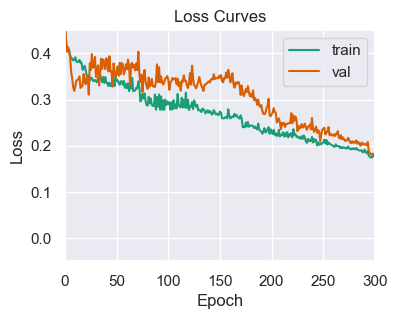

In [45]:
# With recycling.
result = train_by_COBYLA(qnn, xs_train, xs_val, n_epochs=300, initial_weights=initial_weights, live_plot=True)

In [46]:
result.__dict__

{'_x': array([ 0.6047922 ,  0.22470084,  0.34620898, -0.01433091,  1.62923516,
         1.4014905 ,  0.36981028,  1.42440351, -0.72482472,  0.24900164,
         1.15149823,  1.66163762, -1.13122706,  0.08573711,  1.46630929,
         0.16977046,  0.90452427, -1.06216522, -0.0623417 ,  0.14030305,
         1.4227379 ,  0.20693314,  0.06875824,  0.05176905, -0.95089326,
        -0.18320267,  1.47282224,  0.0229301 , -0.645709  ,  1.43940942,
         1.31204422, -0.04397868, -0.06539437,  1.21928451,  1.30743135,
        -0.30740313, -0.00927708,  2.00659198,  0.42179222, -0.04904064,
        -0.06072085,  1.55289396, -0.95852115, -0.11262771,  0.54873776,
        -0.06499429,  0.29869903,  0.34888144]),
 '_fun': 0.17439095159936835,
 '_jac': None,
 '_nfev': 300,
 '_njev': None,
 '_nit': None}

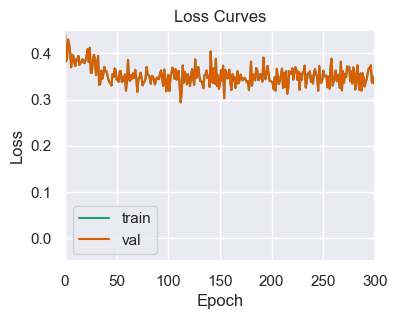

In [47]:
# Without recycling.
result = train_by_COBYLA_no_recylcing(qnn, batch_size=20, n_epochs=300, initial_weights=initial_weights, live_plot=True)

In [48]:
result.__dict__

{'_x': array([ 1.05573889, -0.00266133,  0.05654271,  0.03610445, -0.10472337,
         1.06135993,  0.03397339,  0.0732731 ,  0.88882965,  0.24653489,
        -0.09797636,  0.11095499,  0.03364209,  0.06252032, -0.35177014,
         0.27250504,  0.00944465,  0.21184313,  0.05908723, -0.01802079,
        -0.01354526, -0.02921841,  0.44087404,  0.00819067,  1.06187168,
        -0.06000261, -0.02354266, -0.11428874, -0.08457703,  1.03815611,
         0.03573273,  0.06910806,  0.97627826, -0.02426342, -0.02534527,
        -0.07212568, -0.08461772, -0.02834041, -0.07379297,  0.01555874,
        -0.02791243,  0.06340588,  0.03754813, -0.03608705,  1.06512481,
         0.04682445, -0.03273345, -0.06451545]),
 '_fun': 0.29390803429225654,
 '_jac': None,
 '_nfev': 300,
 '_njev': None,
 '_nit': None}

### Optimisation by PyTorch methods

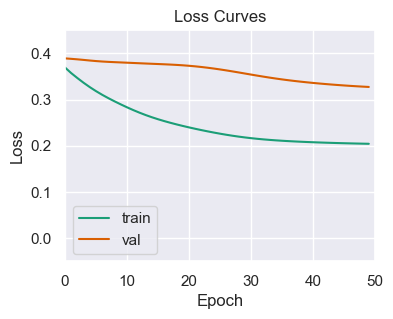

In [51]:
_, _ = train_by_torch(model, train_loader, val_loader, n_epochs=50, lr=1e-2, live_plot=True)